In [2]:
### Model eval
import nemo
import torch
import os
import tempfile
from nemo.collections.nlp.models.language_modeling.megatron_gpt_model import MegatronGPTModel, MegatronSpeechGPTModel
from pytorch_lightning.trainer.trainer import Trainer
from nemo.collections.nlp.parts.nlp_overrides import NLPDDPStrategy, NLPSaveRestoreConnector
from omegaconf import OmegaConf
from pytorch_lightning.plugins.environments import TorchElasticEnvironment
import pytorch_lightning as pl
from nemo.utils import AppState

config = OmegaConf.load("/home/pneekhara/2023/NeMo/examples/nlp/language_modeling/conf/megatron_gpt_prompt_learning_config.yaml")
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
config.trainer.accelerator = accelerator
config.trainer.devices = 1
config.trainer.precision = 16 if torch.cuda.is_available() else 32

os.environ["LOCAL_RANK"] = '0'
os.environ["RANK"] = '0'
os.environ["WORLD_SIZE"] = '1'

# Lightning < 2
strategy = NLPDDPStrategy(find_unused_parameters=False, no_ddp_communication_hook=True)
plugins = [TorchElasticEnvironment()]
trainer = pl.Trainer(plugins= plugins, strategy=strategy, **config.trainer)

# Lightning >= 2
# trainer = pl.Trainer(strategy="auto", **config.trainer)

print("Trainer config - \n")
print(OmegaConf.to_yaml(config.trainer))

# checkpoint_path = "/mnt/drive1/experiments/selene_sgpt_2b_pretrain_11/megatron_sgpt_2b/megatron_gpt--val_loss=4.61-step=46005-consumed_samples=5888000.0-last.ckpt"
# checkpoint_path = "/home/jasoli/experiments/nemo_experiments/megatron_sgpt_843m_linear/checkpoints/megatron_gpt--val_loss=5.74-step=111000-consumed_samples=887984.0.ckpt"
# checkpoint_path = "/mnt/drive1/experiments/sgpt_pretrain_2b_linear_FA_0/08_15_23/training/megatron_sgpt_2b/checkpoints/megatron_gpt--val_loss=5.53-step=21002-consumed_samples=2688000.0-last.ckpt"
# checkpoint_path = "/home/jasoli/experiments/nemo_experiments/megatron_sgpt_843m_linear_delay_embeddingscale/checkpoints/megatron_gpt--val_loss=5.51-step=349000-consumed_samples=5583968.0-last.ckpt"
# checkpoint_path = "/mnt/drive1/experiments/sgpt_pretrain_843m_linearv2/09_08_23/training/megatron_sgpt_843m/checkpoints/megatron_gpt--val_loss=6.34-step=24768-consumed_samples=19016448.0-last.ckpt"
# checkpoint_path = "/home/jasoli/experiments/nemo_experiments/megatron_sgpt_220m_linearv2_delay_embeddingscale/checkpoints/megatron_gpt--val_loss=5.90-step=38000-consumed_samples=2431936.0-last.ckpt"
checkpoint_path = "/datap/misc/gpt_checkpoints/megatron_gpt--val_loss=13.26-step=54000-consumed_samples=13822464.0.ckpt"
# checkpoint_path = "/mnt/drive1/experiments/sgpt_pretrain_2b_linearv2_2/09_20_23/training/megatron_sgpt_2b/checkpoints/megatron_gpt--val_loss=22.58-step=69563-consumed_samples=8904064.0-last.ckpt"
gpt_cfg = MegatronSpeechGPTModel.restore_from(
#     restore_path="/home/jasoli/models/gpt_2b_gtc_tp1_pp1_1_1T/megatron_converted_2b_tp1_pp1.nemo",
#     restore_path="/home/jasoli/models/gpt_843m_gtc_tp1_pp1_1_1T/megatron_converted_843m_tp1_pp1.nemo",
    restore_path="/datap/misc/Checkpoints/converted_megatron_converted_843m_tp1_pp1.nemo",
    trainer=trainer,
    return_config=True,
    save_restore_connector=NLPSaveRestoreConnector(),
    map_location="cpu"
)

def load_from_checkpoint_dir(cls, cfg, trainer, checkpoint):
    app_state = AppState()
#     if cfg.model.tensor_model_parallel_size > 1 or cfg.model.pipeline_model_parallel_size > 1:
#         app_state.model_parallel_size = cfg.model.tensor_model_parallel_size * cfg.model.pipeline_model_parallel_size
#         app_state.tensor_model_parallel_size = cfg.model.tensor_model_parallel_size
#         app_state.pipeline_model_parallel_size = cfg.model.pipeline_model_parallel_size
#         (
#             app_state.tensor_model_parallel_rank,
#             app_state.pipeline_model_parallel_rank,
#             app_state.model_parallel_size,
#             app_state.data_parallel_size,
#             app_state.pipeline_model_parallel_split_rank,
#             app_state.virtual_pipeline_model_parallel_rank,
#         ) = fake_initialize_model_parallel(
#             world_size=app_state.model_parallel_size,
#             rank=trainer.global_rank,
#             tensor_model_parallel_size_=cfg.model.tensor_model_parallel_size,
#             pipeline_model_parallel_size_=cfg.model.pipeline_model_parallel_size,
#             pipeline_model_parallel_split_rank_=cfg.model.pipeline_model_parallel_split_rank,
#         )
#     checkpoint_path = inject_model_parallel_rank(
#         os.path.join(cfg.model.pretrained_checkpoint.checkpoint_dir, cfg.model.pretrained_checkpoint.checkpoint_name)
#     )
#     hparams_file = OmegaConf.load(cfg.model.pretrained_checkpoint.hparams_file)
#     gpt_cfg = _modify_config(hparams_file.cfg, cfg, add_cfg_to_tree=True)
    OmegaConf.resolve(cfg)
    cfg.cfg = cfg
    if "megatron_sgpt_843m_linear_delay_embeddingscale" in checkpoint:
        cfg.cfg.tokenizer.model = "/datap/misc/Checkpoints/gpt843expanded/8c78be8020cb401b9be373a68007f66e_mt_nlg_plus_multilingual_ja_zh_the_stack_frac_015_256k.model"
        cfg.cfg.tokenizer.tokenizer_model = "/datap/misc/Checkpoints/gpt843expanded/8c78be8020cb401b9be373a68007f66e_mt_nlg_plus_multilingual_ja_zh_the_stack_frac_015_256k.model"
        cfg.cfg.override_vocab_size = 256000+1024*8
        cfg.cfg.output_size = 256000+1024
        cfg.cfg.speech_residual_model = None
        cfg.cfg.embedding_scale = 0.33
    elif "megatron_sgpt_220m" in checkpoint:
        cfg.cfg.tokenizer.model = "/datap/misc/Checkpoints/gpt843expanded/8c78be8020cb401b9be373a68007f66e_mt_nlg_plus_multilingual_ja_zh_the_stack_frac_015_256k.model"
        cfg.cfg.tokenizer.tokenizer_model = "/datap/misc/Checkpoints/gpt843expanded/8c78be8020cb401b9be373a68007f66e_mt_nlg_plus_multilingual_ja_zh_the_stack_frac_015_256k.model"
        cfg.cfg.override_vocab_size = 32128+1024*8
        cfg.cfg.output_size = None
        cfg.cfg.speech_residual_model = None
        if "embeddingscale" in checkpoint:
            cfg.cfg.embedding_scale = 0.33
    else:
        print("HEREE")
        cfg.cfg.tokenizer.model = "/datap/misc/Checkpoints/gpt843expanded/8c78be8020cb401b9be373a68007f66e_mt_nlg_plus_multilingual_ja_zh_the_stack_frac_015_256k.model"
        cfg.cfg.tokenizer.tokenizer_model = "/datap/misc/Checkpoints/gpt843expanded/8c78be8020cb401b9be373a68007f66e_mt_nlg_plus_multilingual_ja_zh_the_stack_frac_015_256k.model"
        cfg.cfg.override_vocab_size = 256000+1024*8
        cfg.cfg.output_size = None
        cfg.cfg.speech_residual_model = None
        cfg.cfg.embedding_scale = 0.33
        if "sgpt_pretrain_2b_linearv2_2" in checkpoint:
            cfg.cfg.embedding_scale = 1.      
    with tempfile.NamedTemporaryFile(suffix='.yaml') as f:
        OmegaConf.save(config=cfg, f=f.name)
        model = cls.load_from_checkpoint(checkpoint_path=checkpoint, trainer=trainer, hparams_file=f.name)
        return model

input_type = "delay"
model = load_from_checkpoint_dir(MegatronSpeechGPTModel, gpt_cfg, trainer, checkpoint_path)

import numpy as np
total = 0
for parameter in model.parameters():
    total += np.prod([*parameter.shape])
print(f"total params: {total}")

# print(model.model.module.language_model.output_layer)
# for p in model.model.module.language_model.output_layer.parameters():
#     print(p.shape)
# print(model.model.module.language_model.embedding.word_embeddings)
# for p in model.model.module.language_model.embedding.word_embeddings.parameters():
#     print(p.shape)

from nemo.collections.nlp.modules.common.text_generation_utils import get_default_sampling_params

sampling_params = get_default_sampling_params()
vocab_size = 256000
if "220m" in checkpoint_path:
    sampling_params['add_BOS'] = False
    vocab_size = 32128
sampling_params['vocab_size'] = vocab_size

with torch.no_grad():
    model.float()
    output = model.generate(["Tell me a story about a boy"], None, sampling_params=sampling_params, mode="greedy")
print(output)

Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


Trainer config - 

devices: 1
accelerator: gpu
num_nodes: 1
precision: 16
logger: false
enable_checkpointing: false
replace_sampler_ddp: false
max_epochs: 3
max_steps: -1
log_every_n_steps: 10
val_check_interval: 1.0
gradient_clip_val: 1.0
resume_from_checkpoint: null
benchmark: false

HEREE
[NeMo I 2023-09-26 16:15:07 megatron_init:232] Rank 0 has data parallel group: [0]
[NeMo I 2023-09-26 16:15:07 megatron_init:235] All data parallel group ranks: [[0]]
[NeMo I 2023-09-26 16:15:07 megatron_init:236] Ranks 0 has data parallel rank: 0
[NeMo I 2023-09-26 16:15:07 megatron_init:244] Rank 0 has model parallel group: [0]
[NeMo I 2023-09-26 16:15:07 megatron_init:245] All model parallel group ranks: [[0]]
[NeMo I 2023-09-26 16:15:07 megatron_init:255] Rank 0 has tensor model parallel group: [0]
[NeMo I 2023-09-26 16:15:07 megatron_init:259] All tensor model parallel group ranks: [[0]]
[NeMo I 2023-09-26 16:15:07 megatron_init:260] Rank 0 has tensor model parallel rank: 0
[NeMo I 2023-09-26 

[NeMo W 2023-09-26 16:15:07 nemo_logging:349] /usr/local/lib/python3.8/dist-packages/lightning_fabric/plugins/environments/torchelastic.py:36: UserWarning: MASTER_ADDR environment variable is not defined. Set as localhost
      rank_zero_warn("MASTER_ADDR environment variable is not defined. Set as localhost")
    
[NeMo W 2023-09-26 16:15:07 nemo_logging:349] /usr/local/lib/python3.8/dist-packages/lightning_fabric/plugins/environments/torchelastic.py:44: UserWarning: MASTER_PORT environment variable is not defined. Set as 12910
      rank_zero_warn("MASTER_PORT environment variable is not defined. Set as 12910")
    
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/1
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 1 processes
----------------------------------------------------------------------------------------------------



total params: 840009728


[NeMo W 2023-09-26 16:15:09 nemo_logging:349] /home/pneekhara/2023/NeMo/nemo/collections/nlp/modules/common/text_generation_utils.py:315: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
      string_tensor = torch.as_tensor(
    
[NeMo W 2023-09-26 16:15:09 nemo_logging:349] /usr/local/lib/python3.8/dist-packages/apex/transformer/pipeline_parallel/utils.py:81: UserWarning: This function is only for unittest
      warnings.warn("This function is only for unittest")
    


Doing greedy
{'sentences': [['Tell me a story about a boy who was born in the 1950s and who was killed in a car accident. I asked him if he had ever seen a car', '', '', '', '', '', '', '']], 'tokens': [['<s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']], 'logprob': None, 'full_logprob': None, 'token_ids': [[[2, 24205, 498, 261, 2589, 641, 261, 6139, 624, 431, 6465, 291, 276, 251490, 251525, 251561, 251557, 251521, 251498, 305, 624, 431, 5942, 291, 261, 1091, 8794, 251511, 323, 3452, 1105, 696, 406, 701, 2773, 2820, 261, 1091], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [4]:
from encodec import EncodecModel
from encodec.utils import convert_audio
import IPython.display as ipd

import torchaudio
import torch
import librosa

# Instantiate a pretrained EnCodec model
encodec_model = EncodecModel.encodec_model_24khz()
# The number of codebooks used will be determined bythe bandwidth selected.
# E.g. for a bandwidth of 6kbps, `n_q = 8` codebooks are used.
# Supported bandwidths are 1.5kbps (n_q = 2), 3 kbps (n_q = 4), 6 kbps (n_q = 8) and 12 kbps (n_q =16) and 24kbps (n_q=32).
# For the 48 kHz model, only 3, 6, 12, and 24 kbps are supported. The number
# of codebooks for each is half that of the 24 kHz model as the frame rate is twice as much.
encodec_model.set_target_bandwidth(6)

# Load and pre-process the audio waveform
y, sr = librosa.load("/datap/misc/dev-clean/1272/128104/1272_128104_000003_000005.wav", sr=24000)
ipd.display(ipd.Audio(y, rate=sr))
y = torch.unsqueeze(torch.tensor(y), 0)

wav = convert_audio(y, sr, encodec_model.sample_rate, encodec_model.channels)
wav = wav.unsqueeze(0)

# Extract discrete codes from EnCodec
with torch.no_grad():
    encoded_frames = encodec_model.encode(wav)
codes = torch.cat([encoded[0] for encoded in encoded_frames], dim=-1)  # [B, n_q, T]

with torch.no_grad():
    out_wav = encodec_model.decode([[codes, None]])

if isinstance(out_wav[0], torch.Tensor):
    out_wav = out_wav[0].to('cpu').numpy()
    print(out_wav.shape)
ipd.display(ipd.Audio(out_wav, rate=24000))

from nemo.collections.nlp.modules.common.transformer.text_generation import LengthParam
model.float()
print(input_type)

(1, 223040)


delay


[NeMo W 2023-09-26 16:22:16 nemo_logging:349] /usr/local/lib/python3.8/dist-packages/apex/transformer/pipeline_parallel/utils.py:81: UserWarning: This function is only for unittest
      warnings.warn("This function is only for unittest")
    


Doing teacher forced
(1, 220480)


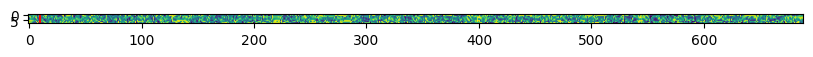

In [5]:
context_length = codes.shape[-1]-1
min_length = 128
max_length = context_length

context_codes = codes[:,:,:context_length].detach().clone()
for i in range(context_codes.shape[1]):
    context_codes[:,i,:] += vocab_size + 1024*i

input_codes = torch.cat((context_codes, torch.zeros([*codes.shape[:-1], max_length], dtype=codes.dtype)), dim=-1)
lengths = LengthParam(min_length=min_length, max_length=max_length)
context_length = torch.tensor([context_length], device=model.device).contiguous()

if input_type=="delay":
    for l in range(1, input_codes.shape[1]):
        input_codes[:, l] = torch.roll(input_codes[:, l], l)
        input_codes[:, l, :l] = 0

with torch.no_grad():
    output = model.generate((input_codes.to(model.device), context_length), lengths, sampling_params=sampling_params)
    
predicted_tensors = torch.tensor(output['token_ids'], device=model.device)

# print(torch.all(input_codes[:,:,:].to(model.device) == predicted_tensors[:,:,:]))

for i in range(8):
    mask = predicted_tensors[:,i,:] != 0.
    predicted_tensors[:,i,:] -= vocab_size + 1024*i
    predicted_tensors[:,i,:] *= mask
# print(predicted_tensors.shape)
# print(predicted_tensors[:,:,125:136])

## Only take predicted tokens form layer 0 and use ground truth for layers 2-8
# pseudo_tensors = torch.cat((predicted_tensors[:,0,:].to(codes.device).unsqueeze(1), codes[:,1:,:384]), dim=1)
# print(pseudo_tensors[:,:,125:136])
# with torch.no_grad():
#     out_wav = encodec_model.decode([[pseudo_tensors.to(codes.device), None]])
predicted_tensors = predicted_tensors[:,:,:context_length]

if input_type=="delay":
    for l in range(1, input_codes.shape[1]):
        predicted_tensors[:, l] = torch.roll(predicted_tensors[:, l], -l)
    predicted_tensors = predicted_tensors[:, :, :-7]

## Take all predicted tokens
with torch.no_grad():
    out_wav = encodec_model.decode([[predicted_tensors.to(codes.device), None]])
if isinstance(out_wav[0], torch.Tensor):
    out_wav = out_wav[0].to('cpu').numpy()
    print(out_wav.shape)
ipd.display(ipd.Audio(out_wav, rate=24000))

%matplotlib inline  
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(10, 60))
ax.imshow(predicted_tensors.cpu().numpy()[0])
plt.axvline(x=10, color="red")

In [6]:
predicted_tensors[:,0,:]

tensor([[ 121,  408,  408,  835,  339,  360,  379,  723,  343,  825,  957,  825,
          719,  574,  148,  148,  738,  106,  488,  488,  499,  267,  722,  687,
          237,  642,  955,  489,  894,  734,   35,  330,  145,  619,  619,  619,
          619,  619,  619,  106,  339,  722,  489,  955,  330,  534,  776,  534,
          776,  955,  394,  955,  164,  136,  344,  534,  619,  619,  619,  738,
          148,  145,  619,  323,  323,  738,  894,  722,  950,  722,  825,  681,
          991,  955,  164,  955,  306,  955,  164,  534,  734,  950,  755,  825,
          723,  489,  723,  489,  534,  585,  534,  164,  534,  255,   80,  670,
          672,   80,  991,  875,  629,  257,  475,  395,  176,  461,  461,  461,
          323,  722,  722,  825,  681,  306,  563,  776,  563,  465,   35,  496,
          303,  303,  303,  534,  585,  955,  988,  394,  921,  327,  619,  629,
          491,  738,  738,  408,  408,  408,  408,  408,  408,  408,  408,  408,
          408,  876,  619,  

In [7]:
raw_output = torch.tensor(output['token_ids'], device=model.device)
print(raw_output[:,0,:])

tensor([[256121, 256408, 256408,  ...,      0,      0,      0]],
       device='cuda:0')


Doing greedy
(1, 40960)


(1, 220480)


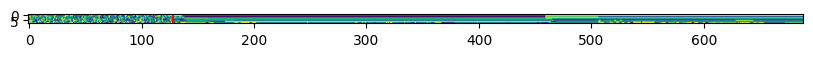

In [8]:
context_length = 128
min_length = 256
max_length = codes.shape[-1]-1
lengths = LengthParam(min_length=min_length, max_length=max_length)
context_length = torch.tensor([context_length], device=model.device).contiguous()

context_codes = codes[:,:,:context_length].detach().clone()
for i in range(context_codes.shape[1]):
    context_codes[:,i,:] += vocab_size + 1024*i

input_codes = torch.cat((context_codes, torch.zeros([*codes.shape[:-1], max_length], dtype=codes.dtype)), dim=-1)
lengths = LengthParam(min_length=min_length, max_length=max_length)
context_length = torch.tensor([context_length], device=model.device).contiguous()

if input_type=="delay":
    for l in range(1, input_codes.shape[1]):
        input_codes[:, l] = torch.roll(input_codes[:, l], l)
        input_codes[:, l, :l] = 0

with torch.no_grad():
    output = model.generate((input_codes.to(model.device), context_length), lengths, sampling_params=sampling_params, mode="greedy")
    
predicted_tensors = torch.tensor(output['token_ids'], device=model.device)

# print(input_codes[:,:,5:20].to(model.device) == predicted_tensors[:,:,5:20])

for i in range(8):
    predicted_tensors[:,i,:] -= vocab_size + 1024*i
# print(predicted_tensors.shape)
# print(predicted_tensors[:,:,125:136])

## Only take predicted tokens form layer 0 and use ground truth for layers 2-8
# pseudo_tensors = torch.cat((predicted_tensors[:,0,:].to(codes.device).unsqueeze(1), codes[:,1:,:384]), dim=1)
# print(pseudo_tensors[:,:,125:136])
# with torch.no_grad():
#     out_wav = encodec_model.decode([[pseudo_tensors.to(codes.device), None]])
predicted_tensors = predicted_tensors[:,:,:max_length]

if input_type=="delay":
    for l in range(1, input_codes.shape[1]):
        predicted_tensors[:, l] = torch.roll(predicted_tensors[:, l], -l)
    predicted_tensors = predicted_tensors[:, :, :-7]

with torch.no_grad():
    out_wav = encodec_model.decode([[codes[:,:,:context_length], None]])

if isinstance(out_wav[0], torch.Tensor):
    out_wav = out_wav[0].to('cpu').numpy()
    print(out_wav.shape)
ipd.display(ipd.Audio(out_wav, rate=24000))

## Take all predicted tokens
with torch.no_grad():
    out_wav = encodec_model.decode([[predicted_tensors.to(codes.device), None]])
if isinstance(out_wav[0], torch.Tensor):
    out_wav = out_wav[0].to('cpu').numpy()
    print(out_wav.shape)
ipd.display(ipd.Audio(out_wav, rate=24000))

%matplotlib inline  
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(10, 60))
ax.imshow(predicted_tensors.cpu().numpy()[0])
plt.axvline(x=128, color="red")

Doing multinomial
(1, 40960)


(1, 220480)


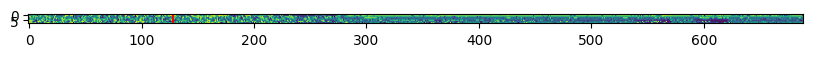

In [9]:
context_length = 128
min_length = 256
max_length = codes.shape[-1]-1
lengths = LengthParam(min_length=min_length, max_length=max_length)
context_length = torch.tensor([context_length], device=model.device).contiguous()

context_codes = codes[:,:,:context_length].detach().clone()
for i in range(context_codes.shape[1]):
    context_codes[:,i,:] += vocab_size + 1024*i

input_codes = torch.cat((context_codes, torch.zeros([*codes.shape[:-1], max_length], dtype=codes.dtype)), dim=-1)
lengths = LengthParam(min_length=min_length, max_length=max_length)
context_length = torch.tensor([context_length], device=model.device).contiguous()

if input_type=="delay":
    for l in range(1, input_codes.shape[1]):
        input_codes[:, l] = torch.roll(input_codes[:, l], l)
        input_codes[:, l, :l] = 0

with torch.no_grad():
    output = model.generate((input_codes.to(model.device), context_length), lengths, sampling_params=sampling_params, mode="multinomial")
    
predicted_tensors = torch.tensor(output['token_ids'], device=model.device)

# print(input_codes[:,:,5:20].to(model.device) == predicted_tensors[:,:,5:20])

for i in range(8):
    predicted_tensors[:,i,:] -= vocab_size + 1024*i
# print(predicted_tensors.shape)
# print(predicted_tensors[:,:,125:136])

## Only take predicted tokens form layer 0 and use ground truth for layers 2-8
# pseudo_tensors = torch.cat((predicted_tensors[:,0,:].to(codes.device).unsqueeze(1), codes[:,1:,:384]), dim=1)
# print(pseudo_tensors[:,:,125:136])
# with torch.no_grad():
#     out_wav = encodec_model.decode([[pseudo_tensors.to(codes.device), None]])
predicted_tensors = predicted_tensors[:,:,:max_length]

if input_type=="delay":
    for l in range(1, input_codes.shape[1]):
        predicted_tensors[:, l] = torch.roll(predicted_tensors[:, l], -l)
    predicted_tensors = predicted_tensors[:, :, :-7]

with torch.no_grad():
    out_wav = encodec_model.decode([[codes[:,:,:context_length], None]])

if isinstance(out_wav[0], torch.Tensor):
    out_wav = out_wav[0].to('cpu').numpy()
    print(out_wav.shape)
ipd.display(ipd.Audio(out_wav, rate=24000))

## Take all predicted tokens
with torch.no_grad():
    out_wav = encodec_model.decode([[predicted_tensors.to(codes.device), None]])
if isinstance(out_wav[0], torch.Tensor):
    out_wav = out_wav[0].to('cpu').numpy()
    print(out_wav.shape)
ipd.display(ipd.Audio(out_wav, rate=24000))

%matplotlib inline  
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(10, 60))
ax.imshow(predicted_tensors.cpu().numpy()[0])
plt.axvline(x=128, color="red")

In [ ]:

# context_codes = codes[:,:,:context_length].detach().clone()
# # tokens_in_round_2 = torch.randint(0, 1024, [1,8,128])

# for i in range(tokens_in_round_2.shape[1]):
#     tokens_in_round_2[:,i,:] += 256000 + 1024*i
    
# tokens_in_round_2 = torch.cat((tokens_in_round_2, torch.zeros([1, 8, 256], dtype=codes.dtype)), dim=-1)

# with torch.no_grad():
#     model.float()
#     output = model.generate((tokens_in_round_2.to(model.device), context_length), lengths)
# predicted_tensors_2 = torch.tensor(output['token_ids'], device=model.device)
# for i in range(8):
#     predicted_tensors_2[:,i,:] -= 256000 + 1024*i
# print(predicted_tensors_2.shape)
# print(predicted_tensors_2[:,:,125:136])

# with torch.no_grad():
#     out_wav = encodec_model.decode([[predicted_tensors_2.to(codes.device), None]])
# if isinstance(out_wav[0], torch.Tensor):
#     out_wav = out_wav[0].to('cpu').numpy()
#     print(out_wav.shape)
# ipd.display(ipd.Audio(out_wav, rate=24000))

# fig, ax = plt.subplots(1, figsize=(10, 60))
# ax.imshow(predicted_tensors_2.cpu().numpy()[0])

In [ ]:
# model.cfg.position_embedding_type

In [ ]:
### Model eval - Evelina's model
import nemo
import torch
import os
import tempfile
from nemo.collections.nlp.models.language_modeling.megatron_gpt_model import MegatronGPTModel, MegatronSpeechGPTModel
from pytorch_lightning.trainer.trainer import Trainer
from nemo.collections.nlp.parts.nlp_overrides import NLPDDPStrategy, NLPSaveRestoreConnector
from omegaconf import OmegaConf
from pytorch_lightning.plugins.environments import TorchElasticEnvironment
import pytorch_lightning as pl
from nemo.utils import AppState

config = OmegaConf.load("/home/jasoli/gitrepos/NeMo/examples/nlp/language_modeling/conf/megatron_gpt_prompt_learning_config.yaml")
# let's modify some trainer configs
# check if we have GPU available and uses it
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
config.trainer.accelerator = accelerator
config.trainer.devices = 1
config.trainer.max_epochs = 4
config.trainer.val_check_interval = 1.0

# for PyTorch Native AMP set precision=16
config.trainer.precision = 16 if torch.cuda.is_available() else 32

# setup cluster environment parameters"
# use torch elastic cluster environment so `create_process_externally` is True
# the launcher is set to None. It will not try to spawn new processes.
# It won't create the misconfiguration error because of the `interactive session`
os.environ["LOCAL_RANK"] = '0'
os.environ["RANK"] = '0'
os.environ["WORLD_SIZE"] = '1'

strategy = NLPDDPStrategy(find_unused_parameters=False, no_ddp_communication_hook=True)
plugins = [TorchElasticEnvironment()]
trainer = pl.Trainer(plugins= plugins, strategy=strategy, **config.trainer)

print("Trainer config - \n")
print(OmegaConf.to_yaml(config.trainer))

# model = MegatronGPTModel
# checkpoint = "/home/jasoli/models/gpt_pretrain_220m_len_4096_pos_alibi_step_595508_gbs256.nemo"
# model = model.restore_from(
#     checkpoint,
#     trainer=trainer,
#     save_restore_connector=NLPSaveRestoreConnector()
# )

model = MegatronSpeechGPTModel
checkpoint = "/home/jasoli/models/speechllm_sgpt_base_220m_tp1_pp1_linear.nemo"

gpt_cfg = MegatronSpeechGPTModel.restore_from(
    restore_path=checkpoint,
    trainer=trainer,
    return_config=True,
    save_restore_connector=NLPSaveRestoreConnector(),
    map_location="cpu"
)
gpt_cfg.override_vocab_size = 32128+1024*8


model = model.restore_from(
    checkpoint,
    trainer=trainer,
    save_restore_connector=NLPSaveRestoreConnector(),
    override_config_path=gpt_cfg
)
model.eval()

from nemo.collections.nlp.modules.common.text_generation_utils import get_default_sampling_params

sampling_params = get_default_sampling_params()
sampling_params['add_BOS'] = False
with torch.no_grad():
    model.float()
    output = model.generate(["Tell me a story about a boy"], None, sampling_params=sampling_params, mode="greedy")
print(output)

## Loading NLP model split 2

# [print(*p.shape) for p in model.model.module.language_model.embedding.parameters()]
# print(model.enc_dec_model.module.encoder_embedding.word_embeddings)
# print(model.tokenizer.legacy)
print(len(model.tokenizer.vocab))
print(model.tokenizer.vocab)

# from nemo.collections.nlp.models.language_modeling.megatron_gpt_prompt_learning_model import get_pseudo_tokens
# tokens = get_pseudo_tokens(8192)
# print(tokens[:10])
# print(model.model.module)
# print(model.model.module.__class__)
# print(model.model.module.post_process)
# for p in model.model.module.language_model.embedding.parameters():
#     param = p
#     break
# [*param.shape, 7]


# with torch.no_grad():
#     model.float()
#     output = model.generate(["Tell me a story"], None)
    
# print(output)
# import numpy as np
# total = 0
# for parameter in model.parameters():
#     total += np.prod([*parameter.shape])
# print(total)
# print(model.model.module.language_model.output_layer.weight.dtype)
# print(model.model.module.language_model.embedding.word_embeddings.embedding_dim)

# for p in model.model.module.language_model.output_layer.parameters():
#     print(p.shape)
# print(model.model.module.language_model.embedding.word_embeddings)
# for p in model.model.module.language_model.embedding.word_embeddings.parameters():
#     print(p.shape)

In [ ]:
### Check that base checkpoint works fine
import nemo
import torch
import os
from nemo.collections.nlp.models.language_modeling.megatron_gpt_model import MegatronSpeechGPTModel
from pytorch_lightning.trainer.trainer import Trainer
from nemo.collections.nlp.parts.nlp_overrides import NLPDDPStrategy, NLPSaveRestoreConnector
from omegaconf import OmegaConf
from pytorch_lightning.plugins.environments import TorchElasticEnvironment
import pytorch_lightning as pl
from nemo.utils import AppState

config = OmegaConf.load("/home/jasoli/gitrepos/NeMo/examples/nlp/language_modeling/conf/megatron_gpt_prompt_learning_config.yaml")
# let's modify some trainer configs
# check if we have GPU available and uses it
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
config.trainer.accelerator = accelerator
config.trainer.devices = 1
config.trainer.max_epochs = 4
config.trainer.val_check_interval = 1.0

# for PyTorch Native AMP set precision=16
config.trainer.precision = 16 if torch.cuda.is_available() else 32

# setup cluster environment parameters"
# use torch elastic cluster environment so `create_process_externally` is True
# the launcher is set to None. It will not try to spawn new processes.
# It won't create the misconfiguration error because of the `interactive session`
os.environ["LOCAL_RANK"] = '0'
os.environ["RANK"] = '0'
os.environ["WORLD_SIZE"] = '1'

strategy = NLPDDPStrategy(find_unused_parameters=False, no_ddp_communication_hook=True)
plugins = [TorchElasticEnvironment()]
trainer = pl.Trainer(plugins= plugins, strategy=strategy, **config.trainer)
save_restore_connector=NLPSaveRestoreConnector()

checkpoint_path = "/home/jasoli/models/speechllm_sgpt_base_843m_tp1_pp1_linear.nemo"
gpt_cfg = MegatronSpeechGPTModel.restore_from(
    restore_path=checkpoint_path,
    trainer=trainer,
    return_config=True,
    save_restore_connector=save_restore_connector,
    map_location="cpu"
)
gpt_cfg.override_vocab_size = 256000+8*1024
gpt_cfg.output_size = 256000+1024
model = MegatronSpeechGPTModel.restore_from(
    checkpoint_path,
    override_config_path=gpt_cfg,
    trainer=trainer,
    save_restore_connector=save_restore_connector
)

with torch.no_grad():
    model.float()
    output = model.generate(["Tell me a story about a boy"], None, mode="greedy")
print(output)

In [ ]:
### Check sample idx npy

from pathlib import Path
import json
import numpy as np

doc_idx = np.load("/mnt/drive1/data/llm_index_mapping_dir/Books3_shuf_text_document_test_indexmap_1327ns_512sl_1234s_doc_idx.npy")
sample_idx = np.load("/mnt/drive1/data/llm_index_mapping_dir/Books3_shuf_text_document_test_indexmap_1327ns_512sl_1234s_sample_idx.npy")
shuffle_idx = np.load("/mnt/drive1/data/llm_index_mapping_dir/Books3_shuf_text_document_test_indexmap_1327ns_512sl_1234s_shuffle_idx.npy")

speech_doc_idx = np.load("/mnt/drive1/data/llm_index_mapping_dir/eng_librivox_22khz_encodec_pt_filepath_document_test_indexmap_2694ns_512sl_1234s_doc_idx.npy")
speech_sample_idx = np.load("/mnt/drive1/data/llm_index_mapping_dir/eng_librivox_22khz_encodec_pt_filepath_document_test_indexmap_2694ns_512sl_1234s_sample_idx.npy")
speech_shuffle_idx = np.load("/mnt/drive1/data/llm_index_mapping_dir/eng_librivox_22khz_encodec_pt_filepath_document_test_indexmap_2694ns_512sl_1234s_shuffle_idx.npy")

sample_idx[0:20]
speech_doc_idx
speech_shuffle_idx
shuffle_idx

In [ ]:
### Make encodec pt jsonl for use in making binary datafile

from pathlib import Path
import json

encodec_pt_folder = Path("/mnt/drive1/data/librilight/encodec_pt")
with open("/mnt/drive1/data/librilight/encodec_pt.jsonl", "w") as f:
    for pt_file in encodec_pt_folder.glob("*.pt"):
        f.write(json.dumps({"encodec_pt_filepath": str(pt_file.resolve())})+'\n')

In [ ]:
### Loading and inspecting NLP model checkpoints

import nemo
import torch
import os
from nemo.collections.nlp.models.language_modeling.megatron_gpt_model import MegatronGPTModel
from nemo.collections.nlp.models.language_modeling import MegatronGPTPromptLearningModel
from nemo.collections.nlp.models.language_modeling.megatron_t5_prompt_learning_model import MegatronT5PromptLearningModel
from pytorch_lightning.trainer.trainer import Trainer
from nemo.collections.nlp.parts.nlp_overrides import NLPDDPStrategy
from omegaconf import OmegaConf
from pytorch_lightning.plugins.environments import TorchElasticEnvironment
import pytorch_lightning as pl


config = OmegaConf.load("/home/jasoli/gitrepos/NeMo/examples/nlp/language_modeling/conf/megatron_gpt_prompt_learning_config.yaml")
# let's modify some trainer configs
# check if we have GPU available and uses it
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
config.trainer.accelerator = accelerator
config.trainer.devices = 1
config.trainer.max_epochs = 4
config.trainer.val_check_interval = 1.0

# for PyTorch Native AMP set precision=16
config.trainer.precision = 16 if torch.cuda.is_available() else 32

# setup cluster environment parameters"
# use torch elastic cluster environment so `create_process_externally` is True
# the launcher is set to None. It will not try to spawn new processes.
# It won't create the misconfiguration error because of the `interactive session`
os.environ["LOCAL_RANK"] = '0'
os.environ["RANK"] = '0'
os.environ["WORLD_SIZE"] = '1'

strategy = NLPDDPStrategy(find_unused_parameters=False, no_ddp_communication_hook=True)
plugins = [TorchElasticEnvironment()]
trainer = pl.Trainer(plugins= plugins, strategy=strategy, **config.trainer)

print("Trainer config - \n")
print(OmegaConf.to_yaml(config.trainer))

# checkpoint_path = "/home/jasoli/models/gpt_2b_gtc_tp1_pp1_1_1T/megatron_converted_2b_tp1_pp1.nemo"
# checkpoint_path = "/home/datasets/jasoli/models/gpt_843m_gtc_tp1_pp1_1_1T/megatron_converted_843m_tp1_pp1.nemo"
checkpoint_path = "/home/jasoli/models/t5_n050104_220m_bf16_O2_tp1_gbs2048_mbs64_r2204.nemo"

# model = MegatronGPTModel.restore_from(checkpoint_path, trainer=trainer, strict=False)
model = MegatronT5PromptLearningModel.restore_from(checkpoint_path, trainer=trainer)

### Loading NLP model split 2
# model.eval()
# # [print(*p.shape) for p in model.model.module.language_model.embedding.parameters()]
# # print(model.enc_dec_model.module.encoder_embedding.word_embeddings)
# # print(model.tokenizer.legacy)
# print(model.tokenizer.vocab)
# from nemo.collections.nlp.models.language_modeling.megatron_gpt_prompt_learning_model import get_pseudo_tokens
# tokens = get_pseudo_tokens(8192)
# print(tokens[:10])
# print(model.model.module)
# print(model.model.module.__class__)
# print(model.model.module.post_process)
# for p in model.model.module.language_model.embedding.parameters():
#     param = p
#     break
# [*param.shape, 7]


# with torch.no_grad():
#     model.float()
#     output = model.generate(["Tell me a story"], None)
    
# print(output)
# import numpy as np
# total = 0
# for parameter in model.parameters():
#     total += np.prod([*parameter.shape])
# print(total)

In [ ]:
### Turn wav to encode pt

from encodec import EncodecModel
from encodec.utils import convert_audio
import IPython.display as ipd

import torchaudio
import torch
import librosa

# Instantiate a pretrained EnCodec model
model = EncodecModel.encodec_model_24khz()
# The number of codebooks used will be determined bythe bandwidth selected.
# E.g. for a bandwidth of 6kbps, `n_q = 8` codebooks are used.
# Supported bandwidths are 1.5kbps (n_q = 2), 3 kbps (n_q = 4), 6 kbps (n_q = 8) and 12 kbps (n_q =16) and 24kbps (n_q=32).
# For the 48 kHz model, only 3, 6, 12, and 24 kbps are supported. The number
# of codebooks for each is half that of the 24 kHz model as the frame rate is twice as much.
model.set_target_bandwidth(3)

# Load and pre-process the audio waveform
y, sr = librosa.load("/home/datasets/VCTK/VCTK-Corpus/wav48/p225/p225_001.wav", sr=24000)
ipd.display(ipd.Audio(y, rate=sr))
y = torch.unsqueeze(torch.tensor(y), 0)

wav = convert_audio(y, sr, model.sample_rate, model.channels)
wav = wav.unsqueeze(0)

# Extract discrete codes from EnCodec
with torch.no_grad():
    encoded_frames = model.encode(wav)
codes = torch.cat([encoded[0] for encoded in encoded_frames], dim=-1)  # [B, n_q, T]
print(y.shape)
print(codes.shape)

### Encodec split 2

from encodec.compress import compress, decompress, MODELS
from encodec.utils import save_audio, convert_audio

for bandwidth in [1.5, 3, 6, 12, 24]:
    model.set_target_bandwidth(bandwidth)

    wav = convert_audio(y, sr, model.sample_rate, model.channels)
    compressed = compress(model, wav, use_lm=False)
    out, out_sample_rate = decompress(compressed)
    print(bandwidth)
    ipd.display(ipd.Audio(out, rate=out_sample_rate))
    
    
### Encodec split 3 
for bandwidth in [1.5, 3, 6, 12, 24]:
    model.set_target_bandwidth(bandwidth)

    wav = convert_audio(y, sr, model.sample_rate, model.channels)
    wav = wav.unsqueeze(0)
    with torch.no_grad():
        encoded_frames = model.encode(wav)
    codes = torch.cat([encoded[0] for encoded in encoded_frames], dim=-1)  # [B, n_q, T]
    print(codes[:,:,:10])